In [1]:
import pandas as pd
import datetime
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab 
import seaborn as sns

In [2]:
sales = pd.read_excel('Online Retail.xlsx')
sales.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   
5    536365     22752         SET 7 BABUSHKA NESTING BOXES         2   
6    536365     21730    GLASS STAR FROSTED T-LIGHT HOLDER         6   
7    536366     22633               HAND WARMER UNION JACK         6   
8    536366     22632            HAND WARMER RED POLKA DOT         6   
9    536367     84879        ASSORTED COLOUR BIRD ORNAMENT        32   

          InvoiceDate  UnitPrice  CustomerID         Country  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom  
5 2010-12-01 08:26:00       7.65     17850.0  United Kingdom  
6 2010-12-01 08:26:00       4.25     17850.0  United Kingdom  
7 2010-12-01 08:28:00       1.85     17850.0  United Kingdom  
8 2010-12-01 08:28:00       1.85     17850.0  United Kingdom  
9 2010-12-01 08:34:00       1.69     13047.0  United Kingdom

## Understand Data through EDA

In [3]:
#Find Number of Unique Customers
len(sales.CustomerID.unique())

4373

In [4]:
#Analyze orders by top 10 customers and what propertion they are of all orders
(sales.CustomerID.value_counts()/sum(sales.CustomerID.value_counts())*100).head(13).cumsum()
#10% of all sells come from top 13 customers
#This is expected as some customers are wholesalers 

17841.0    1.962249
14911.0    3.413228
14096.0    4.673708
12748.0    5.814728
14606.0    6.498553
15311.0    7.110850
14646.0    7.623350
13089.0    8.079807
13263.0    8.492020
14298.0    8.895138
15039.0    9.265809
14156.0    9.614850
18118.0    9.930462
Name: CustomerID, dtype: float64

In [5]:
#check for unique products
len(sales.StockCode.unique())

4070

In [6]:
#check for unique descriptions
len(sales.Description.unique())
#We have a mistmatch between Product and Description

4224

In [7]:
prod_desc = sales.groupby(['StockCode','Description']).count().reset_index()

In [8]:
prod_desc.StockCode.value_counts()[prod_desc.StockCode.value_counts()>1].reset_index()

#One product having multiple descriptions
sales[sales['StockCode'] == prod_desc.StockCode.value_counts()[prod_desc.StockCode.value_counts()>1]
      .reset_index()['index'][2]]['Description'].unique()

array(['CACTI T-LIGHT CANDLES', 'Amazon sold sets', 'dotcom sold sets',
       'wrongly sold sets', '? sold as sets?', 'check', nan], dtype=object)

In [9]:
#Find top selling countries
sales.Country.value_counts().reset_index().head(10)

index  Country
0  United Kingdom   495478
1         Germany     9495
2          France     8557
3            EIRE     8196
4           Spain     2533
5     Netherlands     2371
6         Belgium     2069
7     Switzerland     2002
8        Portugal     1519
9       Australia     1259

In [10]:
#Sales Quantity
sales.Quantity.describe()

count    541909.000000
mean          9.552250
std         218.081158
min      -80995.000000
25%           1.000000
50%           3.000000
75%          10.000000
max       80995.000000
Name: Quantity, dtype: float64

In [11]:
#Sales Unit Price
sales.UnitPrice.describe()

count    541909.000000
mean          4.611114
std          96.759853
min      -11062.060000
25%           1.250000
50%           2.080000
75%           4.130000
max       38970.000000
Name: UnitPrice, dtype: float64

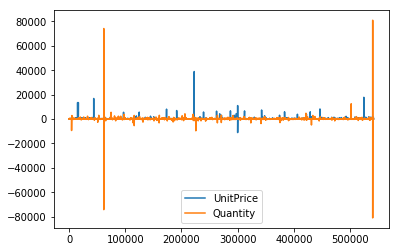

In [12]:
sales[['UnitPrice','Quantity']].plot()
#We can claerly see there are some return transactions

## Data Cleaning and Geographical Separation

### RFM—Recency, Frequency and Monetary Value—based model of customer value for finding our customer segments

In [13]:
sales = sales[sales.Country=='United Kingdom']

#Create Total Amount
sales['Amount'] = sales.Quantity*sales.UnitPrice

#Remove Return Transactions
sales = sales[~(sales.Amount<0)]

#Remove Customer ID null Fields
sales = sales[~(sales.CustomerID.isnull())]
sales.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

          InvoiceDate  UnitPrice  CustomerID         Country  Amount  
0 2010-12-01 08:26:00       2.55     17850.0  United Kingdom   15.30  
1 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34  
2 2010-12-01 08:26:00       2.75     17850.0  United Kingdom   22.00  
3 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34  
4 2010-12-01 08:26:00       3.39     17850.0  United Kingdom   20.34

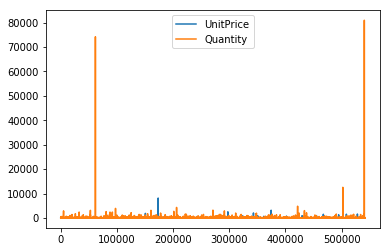

In [14]:
sales[['UnitPrice','Quantity']].plot()

# Create Recency-Monetary-Frequency Features

In [15]:
reference_date = sales.InvoiceDate.max() + datetime.timedelta(days=1)
print(reference_date)

sales['DaysLastPurchase'] = (reference_date-sales.InvoiceDate).astype('timedelta64[D]')
customer_history = 0
customer_history = sales.groupby('CustomerID').min().reset_index()[['CustomerID','DaysLastPurchase']]
customer_history.rename(columns={'DaysLastPurchase':'Recency'},inplace=True)
customer_history.head()

2011-12-10 12:49:00


CustomerID  Recency
0     12346.0    326.0
1     12747.0      2.0
2     12748.0      1.0
3     12749.0      4.0
4     12820.0      3.0

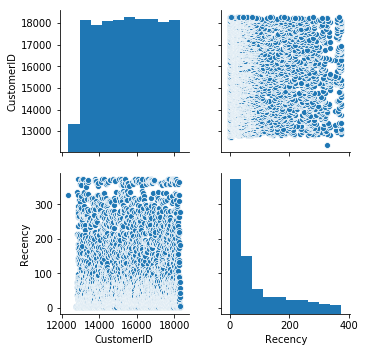

In [16]:
sns.pairplot(customer_history)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: scipy.stats.norm.pdf
  import sys


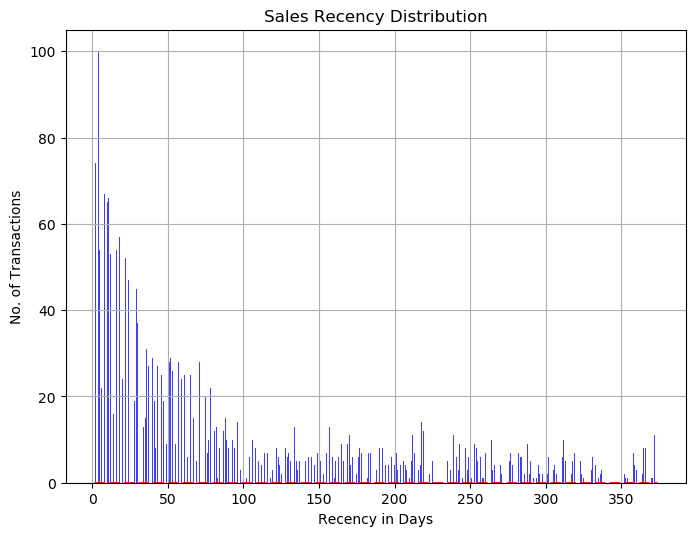

In [17]:
#Check Distribution of Recency 
mu = np.mean(customer_history.Recency)
sigma = np.std(customer_history.Recency)
plt.figure(figsize=(8,6),dpi=100)
n,bins,pathces = plt.hist(customer_history.Recency,1000,facecolor='blue',alpha=0.75)
#add best fit line
y = mlab.normpdf(bins,mu,sigma)
l = plt.plot(bins,y,'r--',linewidth=2)
plt.xlabel('Recency in Days')
plt.ylabel('No. of Transactions')
plt.title('Sales Recency Distribution')
plt.grid(True)

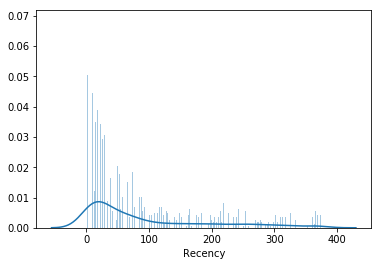

In [18]:
sns.distplot(customer_history.Recency,bins=1000)

In [19]:
#Frequency and Monetary Value
customer_freq = sales[['CustomerID','Amount']].groupby('CustomerID').count().reset_index()
customer_freq.rename(columns={'Amount':'Frequency'},inplace=True)
customer_history = customer_history.merge(customer_freq,how='outer')
customer_monetary = sales[['CustomerID','Amount']].groupby('CustomerID').sum().reset_index()
customer_history = customer_history.merge(customer_monetary,how='outer')
customer_history.Amount = customer_history.Amount+0.001

In [20]:
customer_history.head(5)

CustomerID  Recency  Frequency     Amount
0     12346.0    326.0          1  77183.601
1     12747.0      2.0        103   4196.011
2     12748.0      1.0       4596  33719.731
3     12749.0      4.0        199   4090.881
4     12820.0      3.0         59    942.341

#### Sclae data and log transform for K-Means Clustering 

In [22]:
from sklearn.preprocessing import StandardScaler
customer_history[['Recency_log','Frequency_log','Amount_log']] = np.log(customer_history[['Recency','Frequency','Amount']])
X = customer_history[['Amount_log', 'Recency_log','Frequency_log']].values
X

array([[11.25394229,  5.78689738,  0.        ],
       [ 8.34188959,  0.69314718,  4.63472899],
       [10.42583843,  0.        ,  8.43294164],
       ...,
       [ 5.18207003,  2.07944154,  2.48490665],
       [ 7.64725203,  1.38629436,  6.62804138],
       [ 7.51604204,  3.76120012,  4.24849524]])

In [23]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Text(0.5,1,'Distribution of Log Customer Monetary Value')

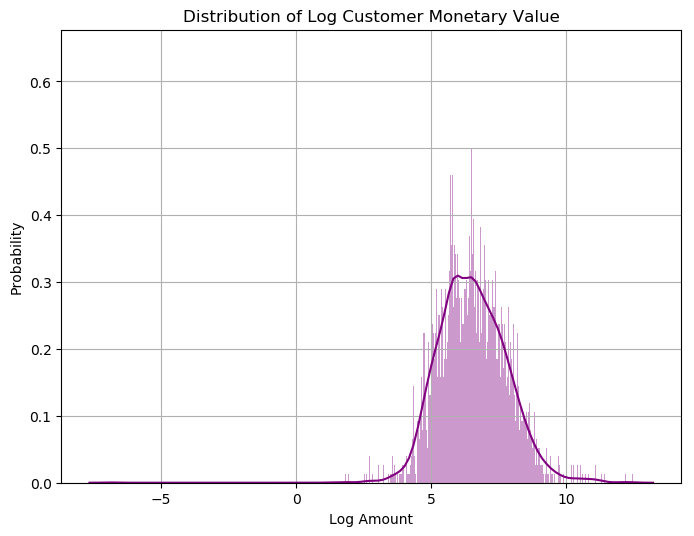

In [24]:
plt.figure(figsize=(8,6), dpi=100)
plt.grid(True)
sns.distplot(customer_history.Amount_log,bins=1000,color='purple')
plt.xlabel('Log Amount')
plt.ylabel('Probability')
plt.title('Distribution of Log Customer Monetary Value')

In [25]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5,0,'Monerary')

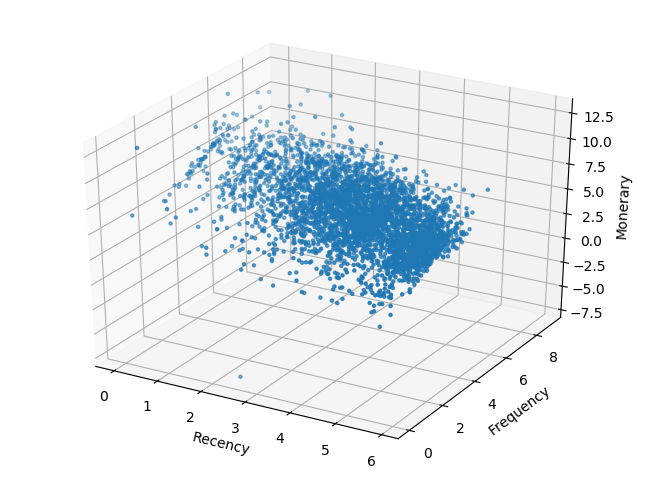

In [26]:
fig = plt.figure(figsize=(8,6), dpi =100)
ax = fig.add_subplot(111,projection='3d')
ax.scatter(customer_history.Recency_log,customer_history.Frequency_log,customer_history.Amount_log,s=5)
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monerary')

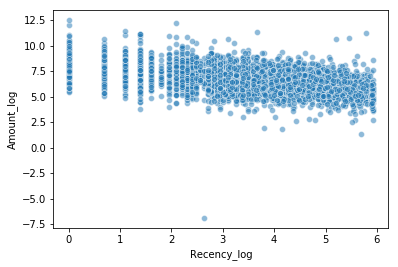

In [27]:
sns.scatterplot(customer_history.Recency_log, customer_history.Amount_log, alpha=0.5)

# Find Customer Segments Using KMeans

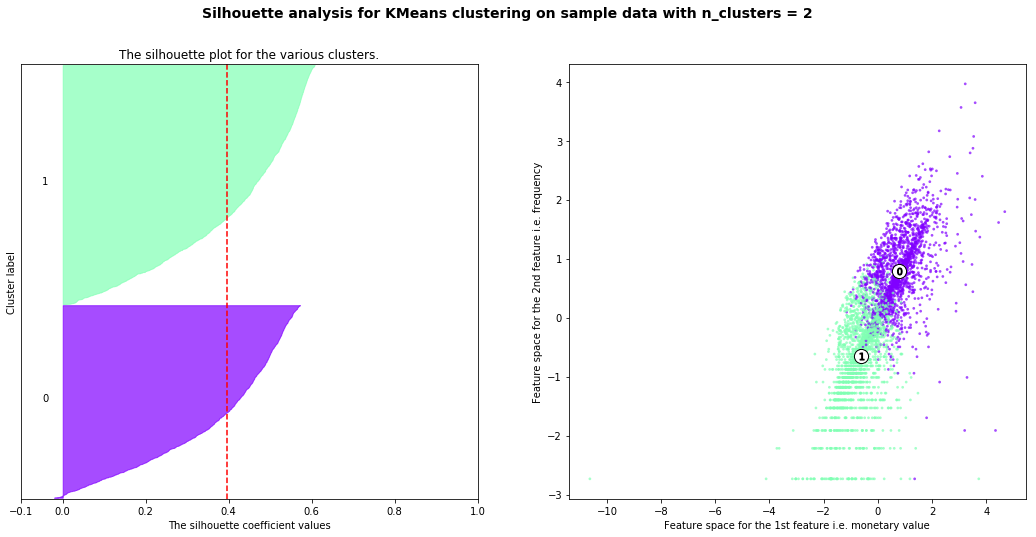

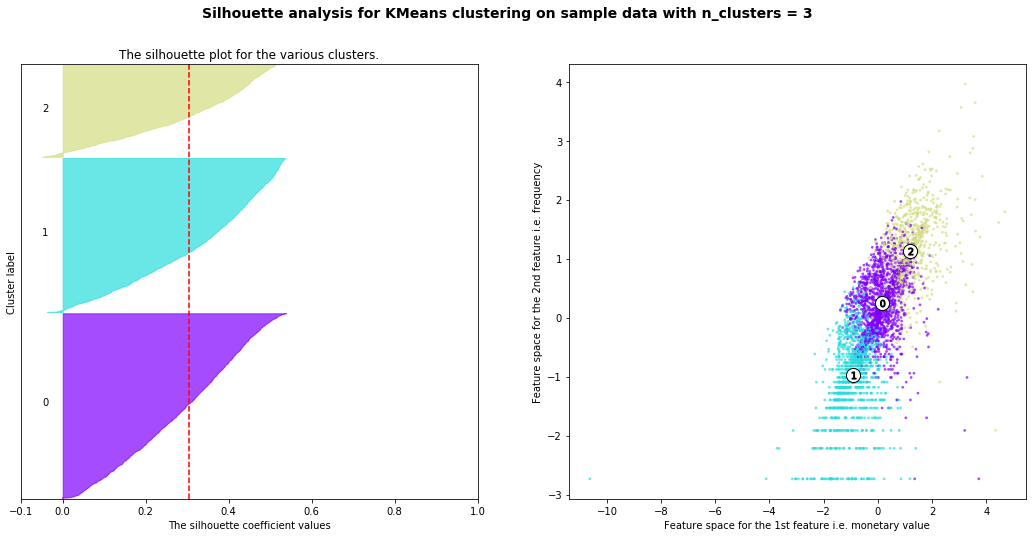

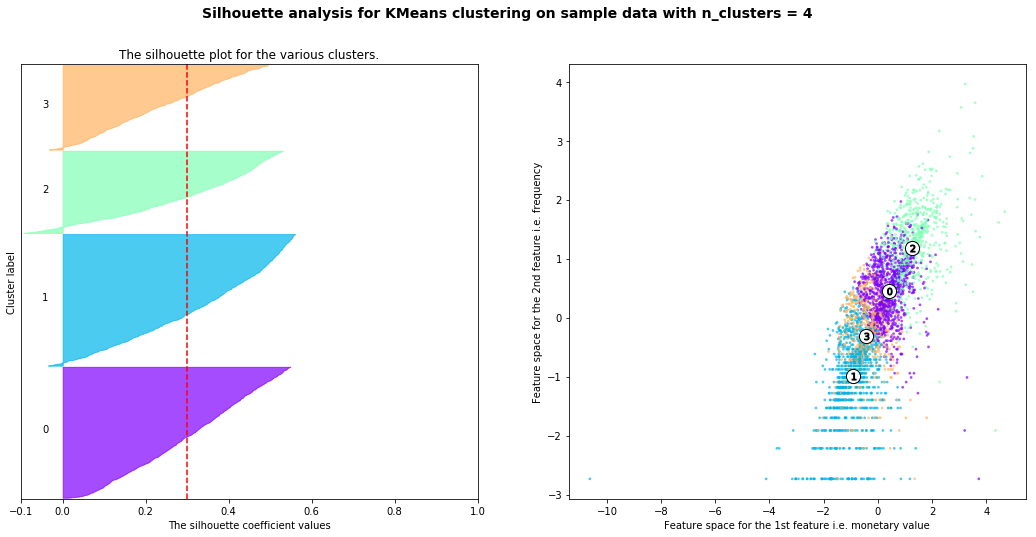

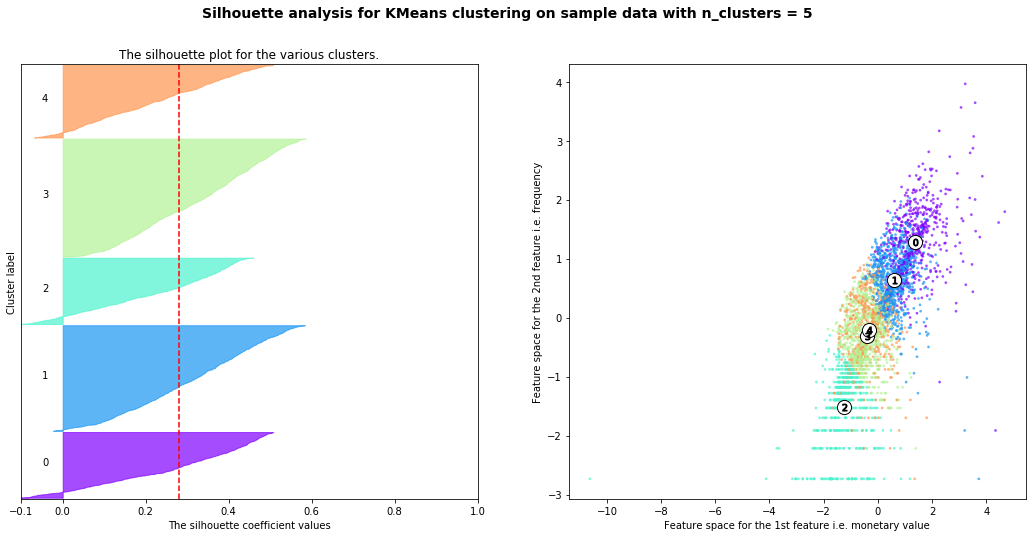

In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

X = X_scaled

centers = dict()

for n_clusters in range(2,6):
    fig,(ax1,ax2) = plt.subplots(1,2)
    fig.set_size_inches(18,8)
    ax1.set_xlim([-0.1,0.1])
    ax1.set_ylim([0,len(X)+(n_clusters+1)*10])
    
    clusterer = KMeans(n_clusters=n_clusters,random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    sil_avg = silhouette_score(X,cluster_labels)
    centers.update({n_clusters:{'cluster_center':clusterer.cluster_centers_,
                                'silhouette_score': sil_avg,
                                'labels':cluster_labels}
                   })
    sample_sil_val = silhouette_samples(X,cluster_labels)
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_sil_val = sample_sil_val[cluster_labels==i]
        ith_cluster_sil_val.sort()
        
        size_cluster_i = ith_cluster_sil_val.shape[0]
        y_upper = y_lower + size_cluster_i
        
        color = cm.rainbow(float(i)/n_clusters)
        ax1.fill_betweenx(np.arange(y_lower,y_upper),0, ith_cluster_sil_val, facecolor=color, edgecolor=color, alpha=0.7)
        ax1.text(-0.05, y_lower+0.5*size_cluster_i, str(i))
        y_lower = y_upper+10 #10 for the zero samples 
        
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")
    ax1.axvline(x=sil_avg, color='red', linestyle='--')
    ax1.set_yticks([])
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
    colors = cm.rainbow(cluster_labels.astype(float)/n_clusters)
    feature1 = 0
    feature2 = 2
    ax2.scatter(X[:,feature1],X[:,feature2], marker = '.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')
    center = clusterer.cluster_centers_
    ax2.scatter(center[:,feature1],center[:,feature2], marker = 'o', s=200, alpha=1, c='white', edgecolor='k')
    
    for i,c in enumerate(center):
        ax2.scatter(c[feature1],c[feature2], marker='$%d$'%i, alpha=1, s=50, edgecolor='k')
        ax2.set_xlabel("Feature space for the 1st feature i.e. monetary value")
        ax2.set_ylabel("Feature space for the 2nd feature i.e. frequency")
        plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')


#### Inspect Cluster Performance and Feature wise Centers

In [29]:
for i in range(2,6):
    print("for {} number of clusters".format(i))
    cent_transformed = scaler.inverse_transform(centers[i]['cluster_center'])
    print(pd.DataFrame(np.exp(cent_transformed),columns=['Amount_log', 'Recency_log','Frequency_log']))
    print("Silhouette score for cluster {} is {}". format(i, centers[i]['silhouette_score']))
    print()

for 2 number of clusters
    Amount_log  Recency_log  Frequency_log
0  1882.387664    15.979529     113.171740
1   308.723197    96.013791      16.442814
Silhouette score for cluster 2 is 0.3947793031805252

for 3 number of clusters
    Amount_log  Recency_log  Frequency_log
0   843.937271    44.083222      53.920633
1   221.236034   121.766072      10.668661
2  3159.294272     7.196647     177.789098
Silhouette score for cluster 3 is 0.30437444714898737

for 4 number of clusters
    Amount_log  Recency_log  Frequency_log
0  1142.609449    65.900731      70.592123
1   220.750870   158.876792      10.405813
2  3393.859424     6.704664     191.017534
3   402.811808    17.889282      25.715470
Silhouette score for cluster 4 is 0.29838466776589245

for 5 number of clusters
    Amount_log  Recency_log  Frequency_log
0  3905.544371     5.627973     214.465989
1  1502.519606    46.880212      92.306262
2   142.867249   126.546751       5.147370
3   408.235418   139.056216      25.530424
4   4

In [30]:
#Create Labels for Clusters and Add to Customer History Data 
labels = centers[5]['labels']   
customer_history['Cluster5labels'] = labels
labels = centers[3]['labels']
customer_history['Cluster3labels'] = labels
labels = centers[4]['labels']
customer_history['Cluster4labels'] = labels
labels = centers[2]['labels']
customer_history['Cluster2labels'] = labels

In [31]:
customer_history.head()

CustomerID  Recency  Frequency     Amount  Recency_log  Frequency_log  \
0     12346.0    326.0          1  77183.601     5.786897       0.000000   
1     12747.0      2.0        103   4196.011     0.693147       4.634729   
2     12748.0      1.0       4596  33719.731     0.000000       8.432942   
3     12749.0      4.0        199   4090.881     1.386294       5.293305   
4     12820.0      3.0         59    942.341     1.098612       4.077537   

   Amount_log  Cluster5labels  Cluster3labels  Cluster4labels  Cluster2labels  
0   11.253942               1               0               0               1  
1    8.341890               0               2               2               0  
2   10.425838               0               2               2               0  
3    8.316516               0               2               2               0  
4    6.848367               4               2               2               0

In [32]:
import plotly as py
import plotly.graph_objs as go
py.offline.init_notebook_mode()

### Create Cluster Feature Visualization Function

In [33]:
def plot_cluster(cluster_label,field_to_plot,ticks,cutoff_quantile):
    l = len(customer_history[cluster_label].unique())
    x_data = ['Cluster 1']
    x_data = [x_data[0][:len(x_data[0])-1] + str(i) for i in range(1,6)]
    
    colors = ['rgba(93, 164, 214, 0.5)', 'rgba(255, 144, 14, 0.5)', 'rgba(44, 160, 101, 0.5)', 
              'rgba(255, 65, 54, 0.5)', 'rgba(207, 114, 255, 0.5)', 'rgba(127, 96, 0, 0.5)']
    cols = []
    y_data = []
    for i in range(l):
        y = customer_history[customer_history[cluster_label]==i][field_to_plot].values
        y_data.append(y[y<np.percentile(y, cutoff_quantile)])
        cols.append(colors[i])
        
    traces = []
    for xd, yd, cls in zip(x_data, y_data, cols):
            traces.append(go.Box(y=yd,name=xd,boxpoints=False,jitter=0.5,whiskerwidth=0.2,fillcolor=cls,
                    marker=dict(size=2,),line=dict(width=1),
            ))

    layout = go.Layout(title='Difference in sales {} from cluster to cluster'.format(field_to_plot),
        yaxis=dict(
            autorange=True,
            showgrid=True,
            zeroline=True,
            dtick= ticks,#50,
            gridcolor='black',
            gridwidth=0.1,
            zerolinecolor='rgb(255, 255, 255)',
            zerolinewidth=2,), 
        margin=dict(l=40,r=30,b=80,t=100,),
        paper_bgcolor='white', plot_bgcolor='white',showlegend=True
    )
    fig = go.Figure(data=traces, layout=layout)
    py.offline.iplot(fig)

In [34]:
plot_cluster('Cluster5labels','Recency',ticks=50, cutoff_quantile = 100)

In [36]:
plot_cluster('Cluster5labels','Recency',ticks=50, cutoff_quantile = 100)

In [37]:
plot_cluster('Cluster5labels','Amount',ticks=1000, cutoff_quantile = 80)

In [38]:
plot_cluster('Cluster5labels','Frequency',ticks=100, cutoff_quantile = 80)

In [39]:
plot_cluster('Cluster3labels','Recency',ticks=50, cutoff_quantile = 100)

In [40]:
plot_cluster('Cluster3labels','Amount',ticks=1000, cutoff_quantile = 80)

In [41]:
plot_cluster('Cluster3labels','Frequency',ticks=100, cutoff_quantile = 90)

In [42]:
plot_cluster('Cluster4labels','Frequency',ticks=100, cutoff_quantile = 90)

# End of Segmentation 

# Write Market Analysis